In [21]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import importlib
import torch
torch.cuda.empty_cache()

import numpy as np
import os
from datetime import datetime
import time

from torch.utils.data import DataLoader

import torch.optim as optim
from torch import nn
from torch.nn.functional import one_hot

import config
import plotUtils
import combinedSequenceEnfomerDataset
import combinedSequenceEnformerModel

importlib.reload(plotUtils)
importlib.reload(config)
importlib.reload(combinedSequenceEnformerModel)
importlib.reload(combinedSequenceEnfomerDataset)

Arguments in plotUtils are {'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/test_combined', 'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latest_training_validation_data/trainingAndValidationExactlyClassBalancedHalfMil_0.00001', 'trainingEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/final_report_enformer_files/training_model_halfmil_attempt_2.hdf5', 'validationEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/final_report_enformer_files/validation_model_halfmil_attempt_2.hdf5', 'trainingDataFile': 'trainingData.pkl', 'validationDataFile': 'validationData.pkl', 'trainingLossLearningRateFile': 'trainingLossLearningRateData.pkl', 'validationLossLearningRateFile': 'validationLossLearningRateData.pkl', 'checkpointsFile': 'modelCheckPoints', 'threshold': 0.5, 'bat

<module 'combinedSequenceEnfomerDataset' from '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/combinedSequenceEnfomerDataset.py'>

In [16]:
arguments = {}

#Model hyperparameters
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.modelHyperParameters.get("learningRate")
arguments["numberOfWorkers"] = config.modelHyperParameters.get("numberOfWorkers")
arguments["numberEpochs"] = config.modelHyperParameters.get("numberEpochs")
arguments["useCosineLearningFunction"] = config.modelHyperParameters.get("useCosineLearningFunction")
arguments["inputSizeToCnn"] = config.modelHyperParameters.get("sequenceDatasetOutputSize")
arguments["dropoutProbability"] = config.modelHyperParameters.get("dropoutProbability")
arguments["weightDecay"] = config.modelHyperParameters.get("weightDecay")

#Enformer related configs
arguments["trainingStartIndex"] = config.modelGeneralConfigs.get("startIndexEnformerSamplesTraining")
arguments["validationStartIndex"] = config.modelGeneralConfigs.get("startIndexEnformerSamplesValidation")

#Model general configs
arguments["addLengthAsFeature"] = config.modelGeneralConfigs.get("addLengthAsFeature")

#Configs and file paths required for restoring from checkpoint
arguments["restoreFromCheckpoint"] = config.testConfigs.get("restoreFromCheckpoint")
arguments["storePlots"] = config.testConfigs.get("storePlots")
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")
arguments["trainingAndValidationOutputsDirectory"] = config.testFilePaths.get("trainingAndValidationOutputsDirectory")
arguments["checkpointsFile"] = config.filePaths.get("checkpointsFile")
arguments["restoreCheckpointModelDirName"] = config.filePaths.get("restoreCheckpointModelDirName")

In [17]:
def trainCombinedModelAndGetPredictions(combinedSequenceEnformerModel, dataloader, criterion, 
                              isTraining=False, optimizer = False):
    plotsData = {} 
    
    modelPredictionsToRet = np.zeros(shape = (1, 2))
    modelInputLabelsToRet = []
    learningRates = []
    
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        sequenceOutput, enformerOutput, og_sequence_length, classLabels = data
        if torch.cuda.is_available():
            #While creating torch.tensor, device can be passed as cuda. But that was a suspect for GPU node running out of memory.
            #After iterating through dataset and fetching each sample, send the labels and sequence to cuda
            #The class labels should be of type integer. 
            #TODO modify sampler function 
            #Because we use the sampler, there is an extra dimension for the labels and enformer output. [1*128*10626].
            #Take only the 1st element to remove the extra dimension. 
            enformerOutput = enformerOutput[0].to('cuda')
            sequenceOutput = sequenceOutput[0].to('cuda')
            batches, sequence_length, one_hot_base_length = sequenceOutput.shape
            sequenceOutput = sequenceOutput.reshape(batches, 1, sequence_length, one_hot_base_length)
            classLabels = classLabels.to(torch.int64)[0].flatten().to('cuda')
            og_sequence_length =  og_sequence_length[0].reshape(len(og_sequence_length[0]), 1).to("cuda")

        #The class labels have to be encoded into probabilities of type floating point
        probabilityLabels = one_hot(classLabels, num_classes=2).to(torch.float32)

        modelPrediction = combinedSequenceEnformerModel(sequenceOutput, enformerOutput, og_sequence_length, arguments["addLengthAsFeature"])
        loss = criterion(modelPrediction, probabilityLabels)
    
        #If the model is being trained, then do backpropagation and calculate loss. 
        if(isTraining):
            #zero grad is applicable only for optimizers and not for cosine annealing function schedulers. 
            if arguments["useCosineLearningFunction"] != True:
                optimizer.zero_grad()

            # Backward pass and calculate the gradients
            loss.backward()
            optimizer.step()

        #Collect data for plotting graphs
        running_loss += loss.item()
        if arguments["useCosineLearningFunction"] and isTraining:
                learningRates.append(optimizer.get_lr())
        # modelInputDataToRet =  np.row_stack([modelInputDataToRet, enformerOutput.detach().cpu().numpy()])
        modelInputLabelsToRet.extend(classLabels.cpu())
        modelPredictionsToRet = np.row_stack([modelPredictionsToRet, modelPrediction.detach().cpu().numpy()])
    
    avg_loss_per_batch = running_loss/len(dataloader)
    plotsData["labels"] = modelInputLabelsToRet
    plotsData["predictions"] = modelPredictionsToRet[1:, :]

    return plotsData, avg_loss_per_batch, learningRates

In [18]:
def objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path):
    trainingPlotsData = {"labels": {}, "predictions": {}, "inputData": {}, "loss": {}, "learningRates": {}}
    validationPlotsData = {"labels": {}, "predictions": {}, "inputData": {}, "loss": {}, "learningRates": {}}
    

    denseLayerModel = combinedSequenceEnformerModel.combinedSequenceEnformerModel(arguments["dropoutProbability"]).to('cuda')
    
    #Training dataloader
    trainingDataset = combinedSequenceEnfomerDataset.combinedSequenceEnfomerDataset("training")
    rangeTrainingSampler = range(arguments["trainingStartIndex"] , len(trainingDataset) + arguments["trainingStartIndex"])
    trainingsampler = torch.utils.data.BatchSampler(rangeTrainingSampler, batch_size=batchSize,
                                            drop_last=False )
    trainingDataloader = DataLoader(trainingDataset,  num_workers=numWorkers, sampler=trainingsampler)

    #Validation dataloader TODO uncomment once validation enformer output file is ready. 
    validationDataset = combinedSequenceEnfomerDataset.combinedSequenceEnfomerDataset("validation")
    rangeValidationSampler = range(arguments["validationStartIndex"] , len(validationDataset) + arguments["validationStartIndex"])
    validation_sampler = torch.utils.data.BatchSampler(rangeValidationSampler, batch_size=batchSize,
                                            drop_last=False)
    validationDataloader = DataLoader(validationDataset, num_workers=numWorkers, sampler=validation_sampler)

    print(f"Number of training samples and validation samples are {len(trainingDataset)} and {len(validationDataset)}")
    #Get loss function
    training_class_weights = trainingDataset.getClassWeights()
    criterion = nn.CrossEntropyLoss(weight = torch.tensor(training_class_weights).to('cuda'))


    #If restoring from a previous checkpoint, load the modek and optimizer state dict 
    epoch_to_start = 1

    if(arguments["restoreFromCheckpoint"]):
        checkpoint_path = os.path.join(plots_directory_path, arguments["checkpointsFile"])
        checkpoint_dict = torch.load(checkpoint_path)
        denseLayerModel.load_state_dict(checkpoint_dict["model_state_dict"])
        epoch_to_start = checkpoint_dict["epoch"] + 1
        print(f"Restore from checkpoint is True.. loading previous model checkpoint and starting from epoch : {epoch_to_start}")
    
    training_num_batches = len(trainingDataloader)
    optimizer = optim.Adam(denseLayerModel.parameters(), lr=learningRate)

    if(arguments["restoreFromCheckpoint"]):
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])

    if arguments["useCosineLearningFunction"]:
        optimizer_steps = (training_num_batches * numEpochs) #Number of steps in gradient descent. 
        optimizer_to_use_for_training = optim.lr_scheduler.CosineAnnealingLR(optimizer, optimizer_steps, last_epoch = epoch_to_start - 2, eta_min=0)
    else:
        optimizer_to_use_for_training = optimizer
        
    #Train model and validate it for each epoch
    for epoch in range(epoch_to_start, numEpochs + 1):
        print(f"Starting training for epoch {epoch}")
        trainingPlotsData, training_loss, training_learning_rates = trainCombinedModelAndGetPredictions(denseLayerModel, 
                                            trainingDataloader, criterion, isTraining=True, optimizer=optimizer_to_use_for_training)
        trainingPlotsData["epoch"] = epoch
        print(f"Finished training for epoch {epoch}. Starting validations")
        
        #Validation
        with torch.no_grad():
            validationPlotsData, validation_loss, validation_learning_rates = trainCombinedModelAndGetPredictions(denseLayerModel, 
                                                validationDataloader, criterion, isTraining=False)
            validationPlotsData["epoch"] = epoch

        #For every epoch, save the model checkpoint and the plotsData so far. 
        plotUtils.saveModelCheckpoint(epoch, denseLayerModel, optimizer, plots_directory_path)
        plotUtils.savePlotsData("training", trainingPlotsData, training_loss, training_learning_rates, plots_directory_path)
        plotUtils.savePlotsData("validation", validationPlotsData, validation_loss, validation_learning_rates, plots_directory_path)

    print(f"Completed training and validation. Saving model and plotting loss function graphs. ")
    plotUtils.storePlots(plots_directory_path, modelInputType="Enformer")

Start time is 1699987564.9253068
The model hyper parameters are Learning Rate: 1e-05, numWorkers: 12, numEpochs: 2, batchSize: 128
Enformer output file path is /hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/training_model_halfmil_attempt_2.hdf5
Inside all
Enformer output file path is /hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/validation_model_halfmil_attempt_2.hdf5
Inside all
Starting training for epoch 1
Finished training for epoch 1. Starting validations
Inside save model check point
Starting training for epoch 2
Finished training for epoch 2. Starting validations
Inside save model check point
Completed training and validation. Saving model and plotting loss function graphs. 


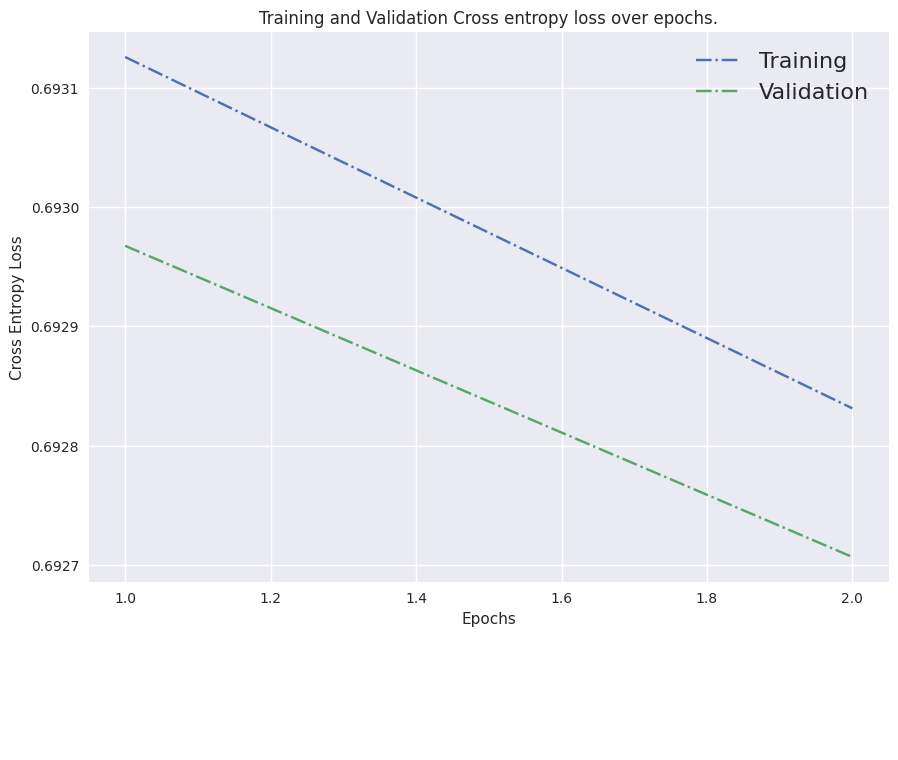

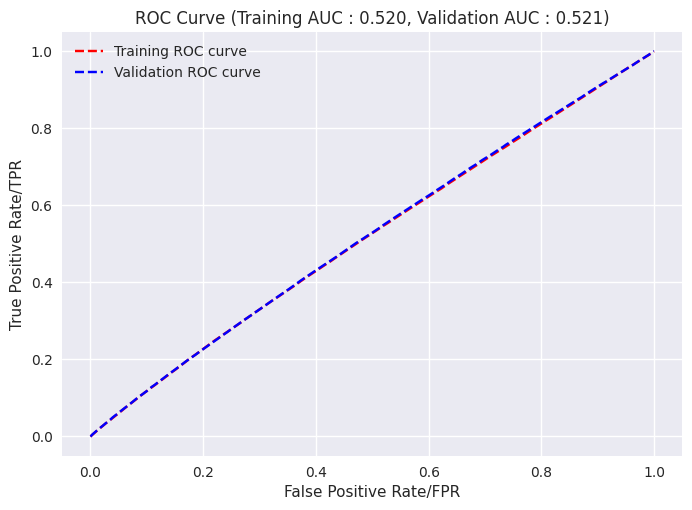

<Figure size 800x550 with 0 Axes>

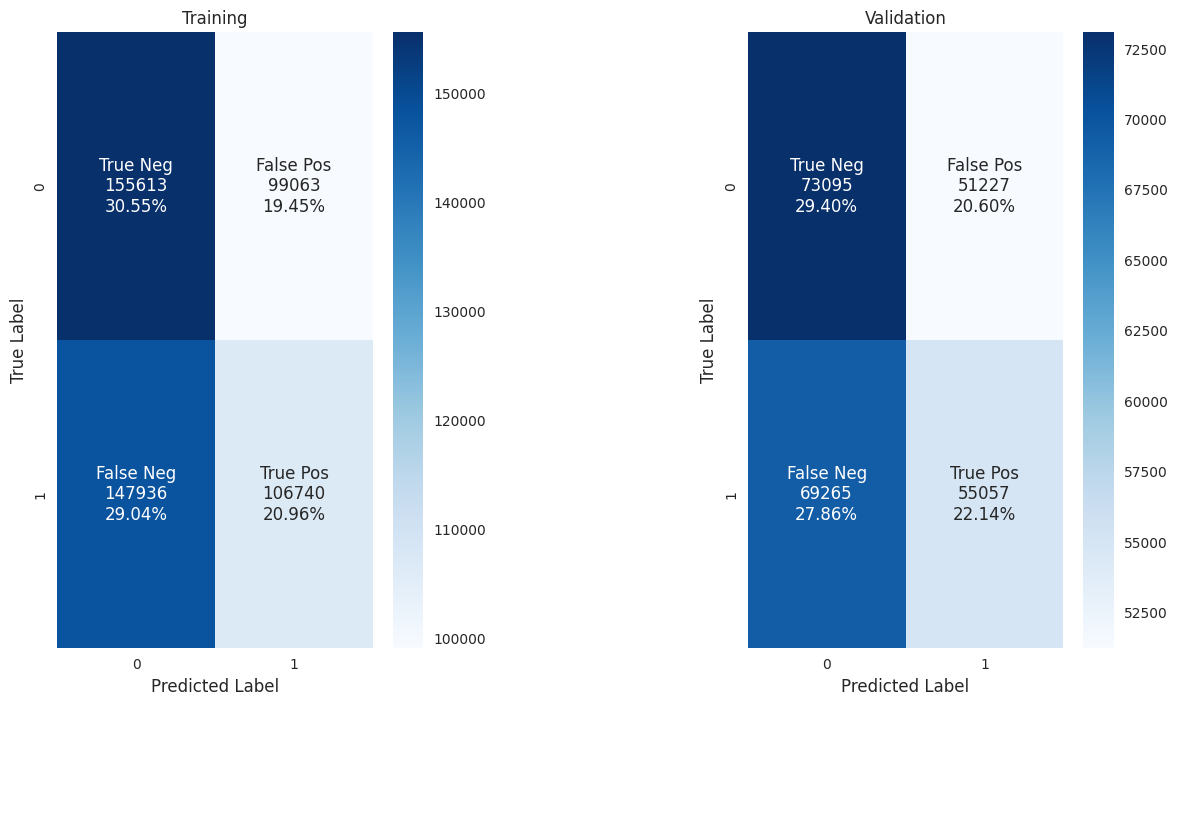

<Figure size 800x550 with 0 Axes>

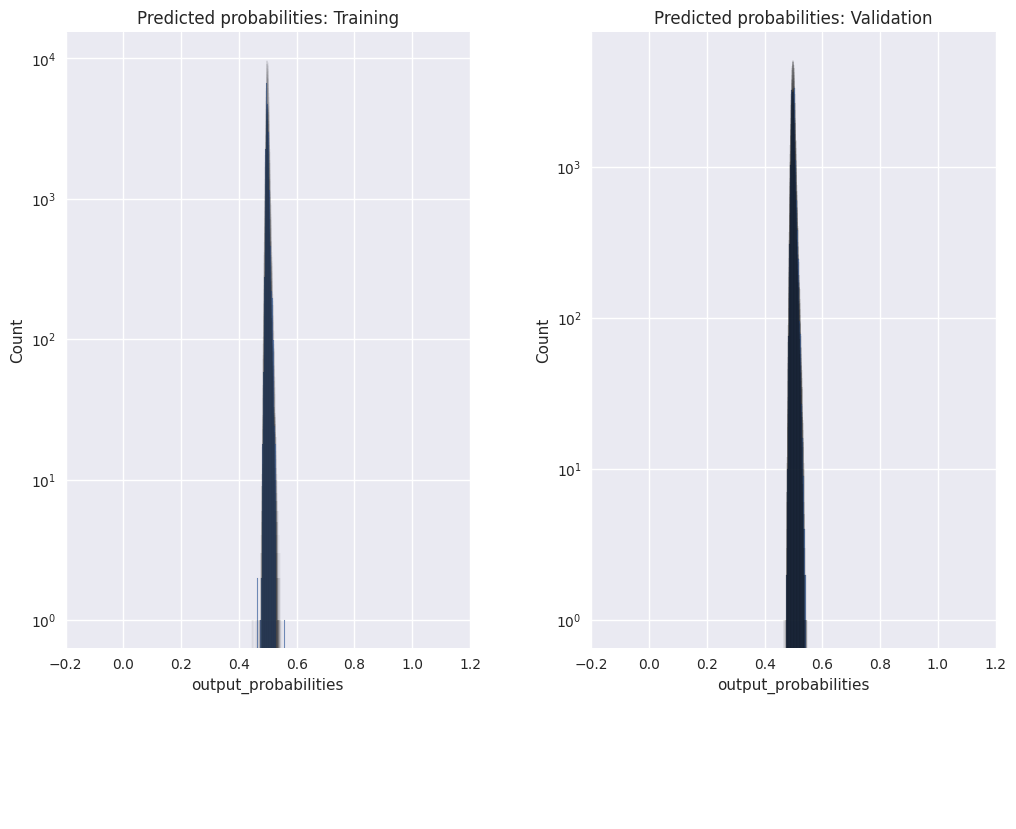

<Figure size 800x550 with 0 Axes>

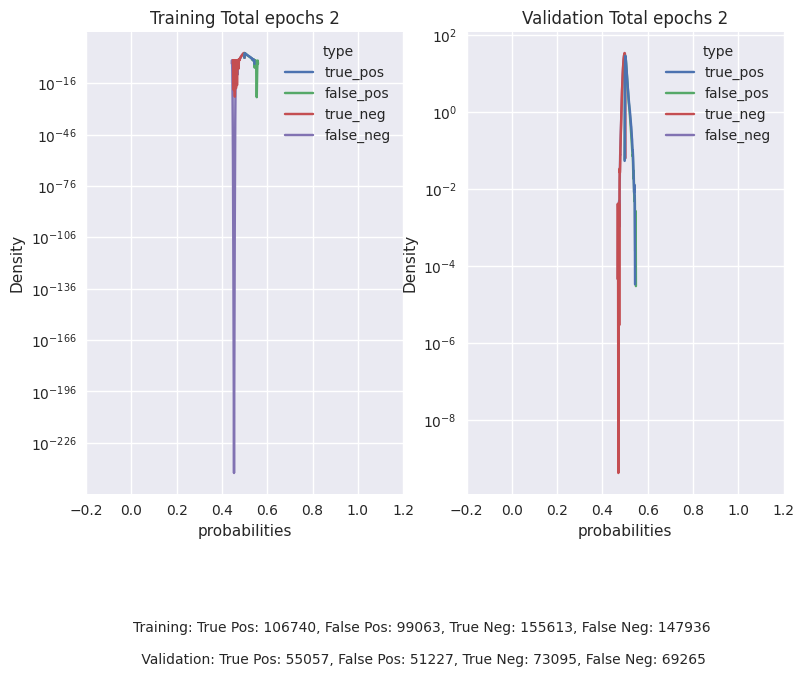

End time is 1699988073.7700033


In [22]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")
    learningRate = arguments["learningRate"]
    numWorkers = arguments["numberOfWorkers"]
    numEpochs = arguments["numberEpochs"]
    batchSize = arguments["batchSize"]

    print(f"The model hyper parameters are Learning Rate: {learningRate}, numWorkers: {numWorkers}, numEpochs: {numEpochs}, batchSize: {batchSize}")
    
    #Create the directories for plots and checkpoints
    if(arguments["restoreFromCheckpoint"]):
        plots_directory_name = arguments["restoreCheckpointModelDirName"]
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
    else:
        now = datetime.now()
        filename_extension = now.strftime("%d_%m_%H_%M_%S")
        plots_directory_name = filename_extension + "_" + str(arguments["modelName"])
        plots_directory_path = os.path.join(arguments["trainingAndValidationOutputsDirectory"], plots_directory_name)
        os.mkdir(plots_directory_path)

    objectiveFn(learningRate, numWorkers, batchSize, numEpochs, plots_directory_path)
    print(f"End time is {time.time()}")

In [ ]:
import torchvision.transforms.functional as tf
example_2D_list = [[5.0, 23.0, 15.0, 20.0],
                   [25.0, 30.0, 35.0, 40.0],
                   [45.0, 50.0, 55.0, 60.0]]
t = torch.tensor(example_2D_list)
print(f"{t.shape[0]}, {t.shape[1]}")
t = t.reshape(1, 3, 4)
print(f"New t1 {t.shape}")
t = t.reshape(t.shape[1], t.shape[2])
print(f"New t2 shape : {t.shape}")
print(t)
mean = torch.mean(t, axis = 1)
std = torch.std(t, axis = 1)
t = t.reshape(1, t.shape[0], t.shape[1])
print(f"t: {t.shape}, mean: {mean.shape} and std: {std.shape}")
new_t = tf.normalize(t, mean, std) 
print(new_t)

In [ ]:
import torch.nn.functional as f
example_2D_list= [[5.0, 23.0, 15.0, 20.0],
                   [25.0, 30.0, 35.0, 40.0],
                   [45.0, 50.0, 55.0, 60.0]]
t = torch.tensor(example_2D_list)
new_t = f.normalize(t, dim=0, p = 1)
print(new_t.shape)
print(new_t)

In [14]:
trainingDataset = combinedSequenceEnfomerDataset.combinedSequenceEnfomerDataset("training")
print(len(trainingDataset))

Enformer output file path is /hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/final_report_enformer_files/training_final_model_500k_0.00001.hdf5
Inside all
510952
